In [1]:
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
import numpy as np
import pandas as pd

sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

/Users/annadanese/anaconda3/lib/python3.8/site-packages/scanpy/api/__init__.py:3: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  warnings.warn(


# Load the raw data

In [86]:
adata = ad.read('atac_v1_pbmc_5k_singlecell_peaks_all_chrom.h5ad')
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 8297 × 195996
    var: 'batch'

## Load metadata & filter barcodes for the comparison

In [88]:
metadata = pd.read_csv('../input/metadata.tsv',sep='\t',index_col=0)
cell_name = metadata.index.tolist()
annot = []
for cell in adata.obs_names.tolist():
    if cell in cell_name:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter'] = annot
adata = adata[adata.obs['filter']=='keep',:].copy()
del adata.obs['filter'], metadata, annot
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5018 × 195996
    var: 'batch'

### Preliminary filtering

In [89]:
epi.pp.filter_cells(adata, min_features=1)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5018 × 195996
    obs: 'nb_features'
    var: 'batch'

In [90]:
epi.pp.filter_features(adata, min_cells=50)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5018 × 139051
    obs: 'nb_features'
    var: 'batch', 'n_cells'

In [91]:
epi.pp.binarize(adata)
np.max(adata.X)

1.0

In [92]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 5018 × 139051
    obs: 'nb_features', 'log_nb_features'
    var: 'batch', 'n_cells'

# Quality Control

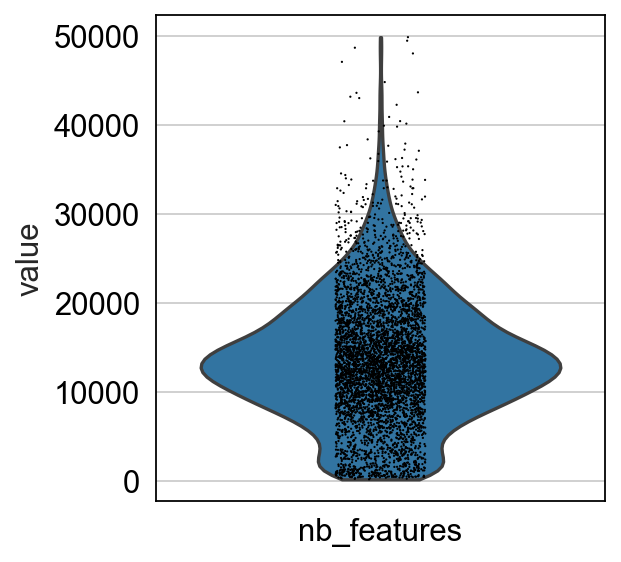

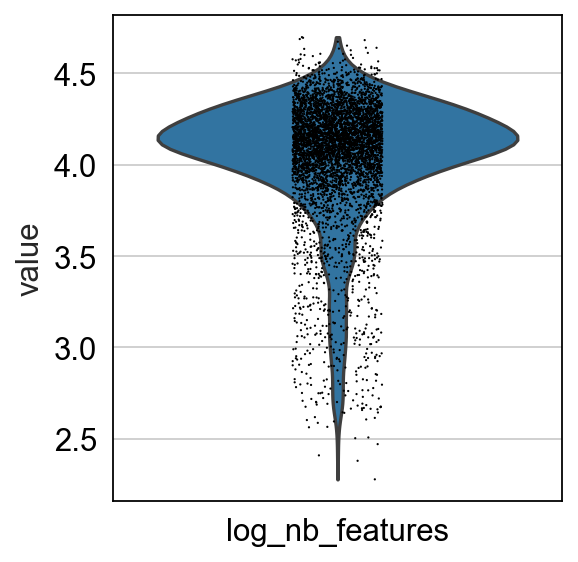

In [93]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

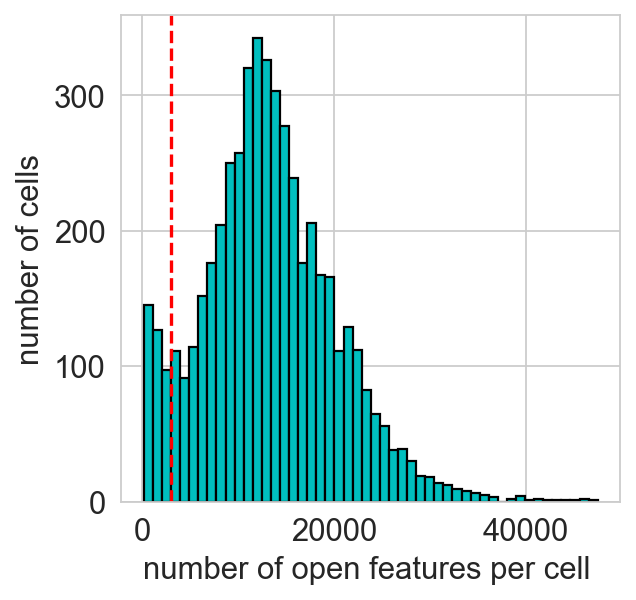

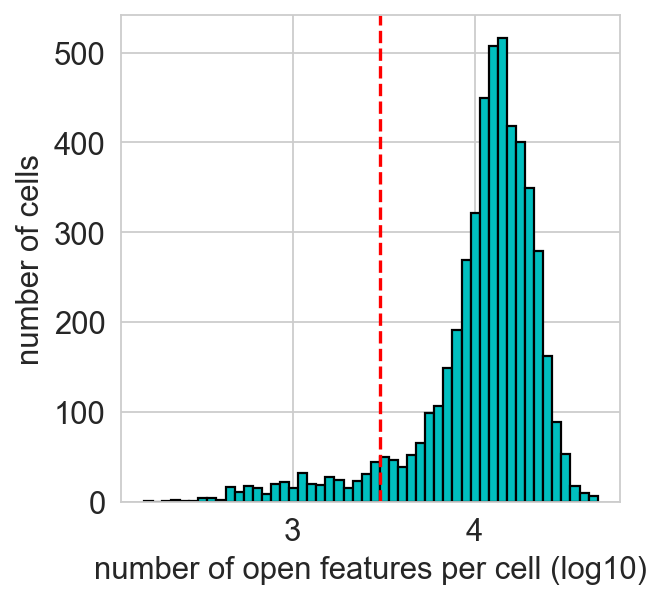

In [95]:
# set a minimum number of cells to keep 
min_features = 3000

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_coverage_cells_log10.png')

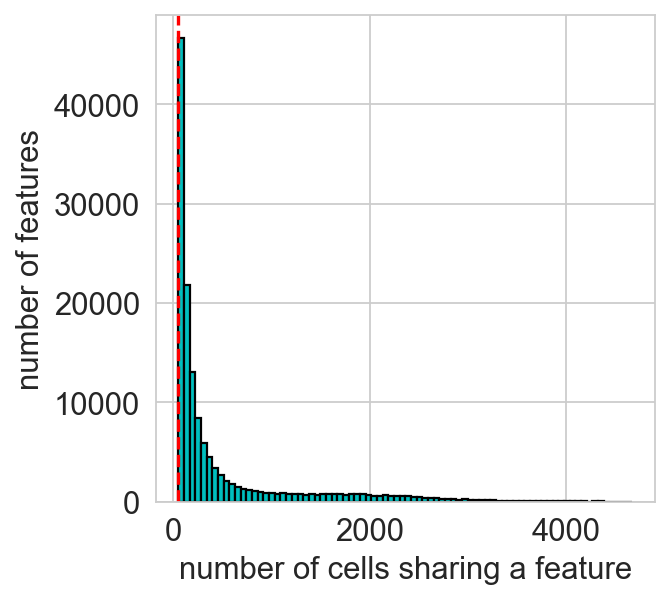

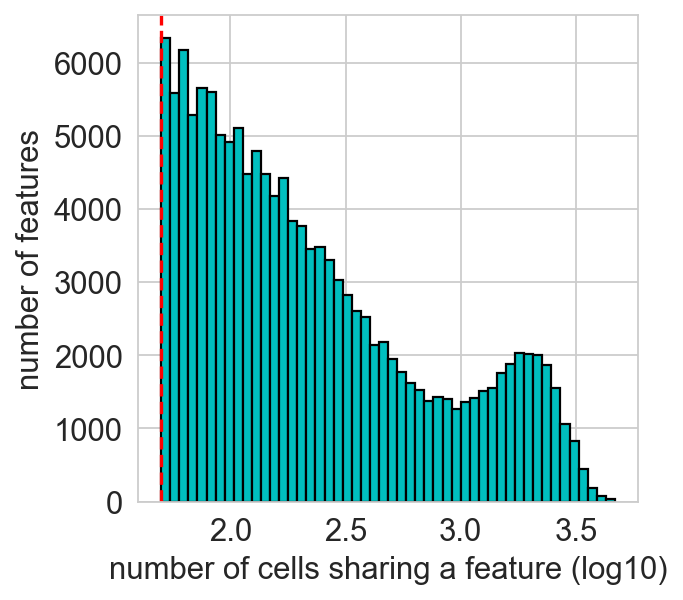

In [96]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_feature_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_feature_coverage_log10.png')

In [97]:
min_features = 3000
epi.pp.filter_cells(adata, min_features=min_features)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4645 × 139051
    obs: 'nb_features', 'log_nb_features'
    var: 'batch', 'n_cells', 'commonness'

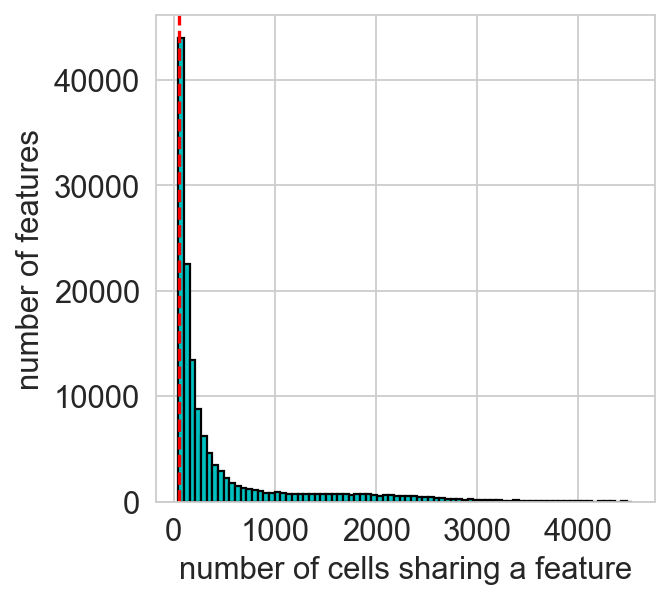

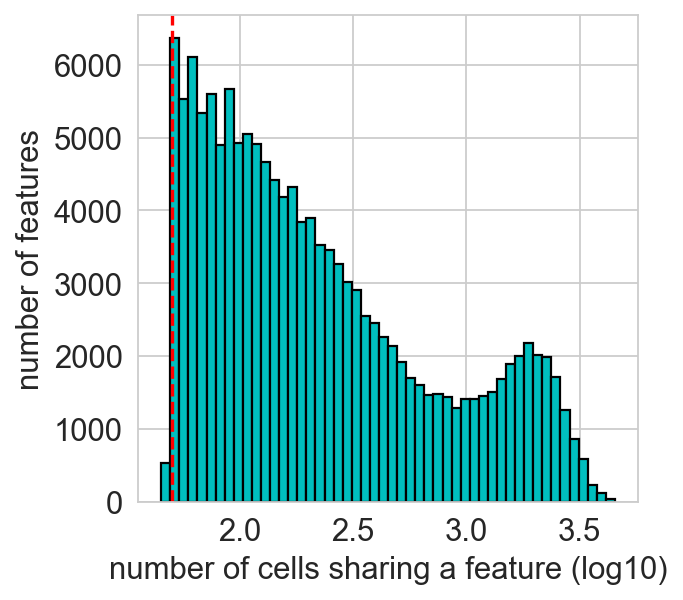

In [98]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_feature_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_feature_coverage_log10.png')

In [99]:
min_cells = 50
epi.pp.filter_features(adata, min_cells=min_cells)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4645 × 138516
    obs: 'nb_features', 'log_nb_features'
    var: 'batch', 'n_cells', 'commonness'

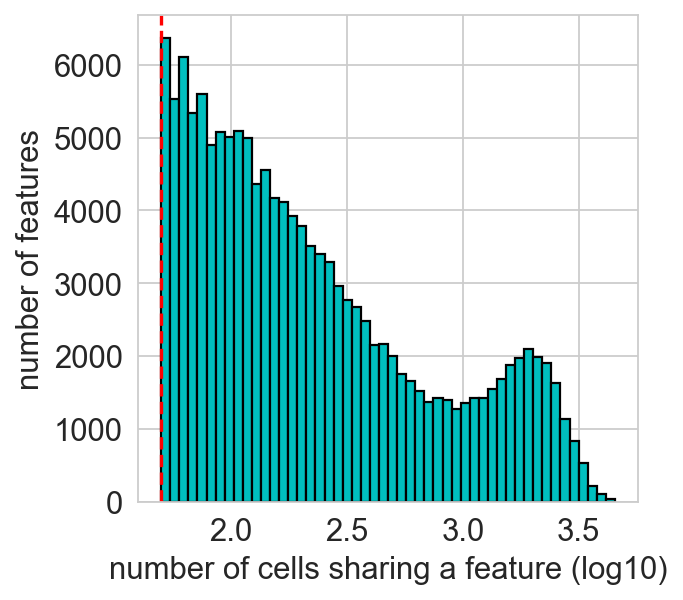

In [100]:
#epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

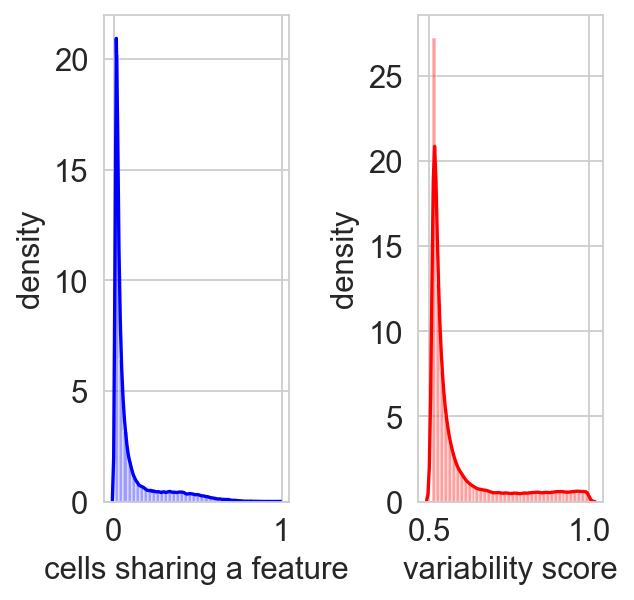

In [101]:
epi.pp.cal_var(adata)

In [102]:
adata

AnnData object with n_obs × n_vars = 4645 × 138516
    obs: 'nb_features', 'log_nb_features'
    var: 'batch', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

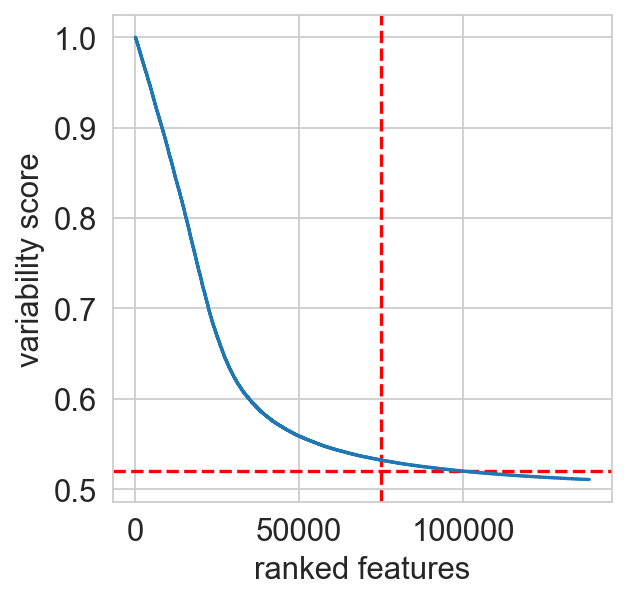

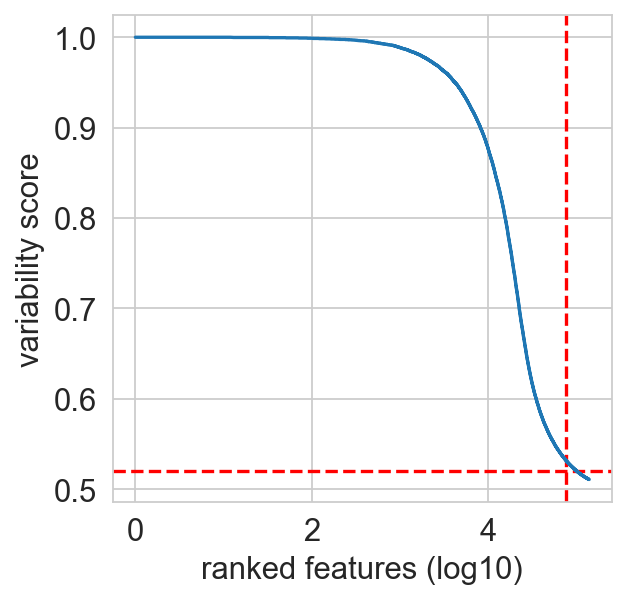

In [103]:
min_score_value = 0.52
nb_feature_selected = 75000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x.png')

In [104]:
# save the current matrix in the raw layer
adata.raw = adata

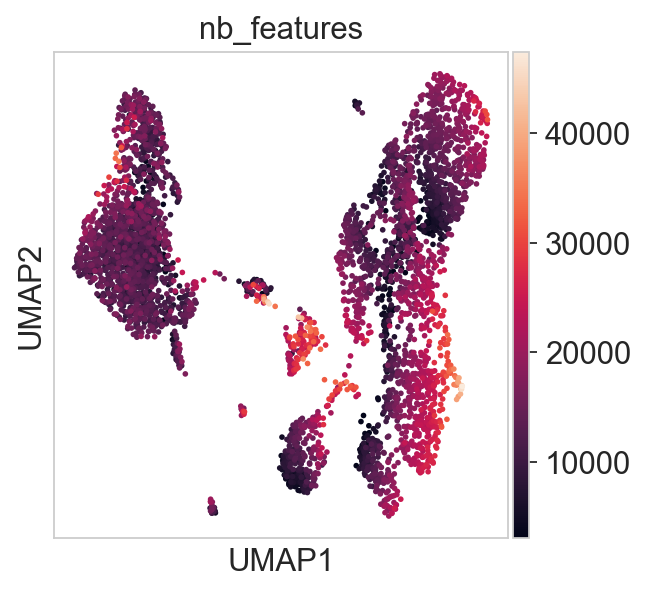

In [107]:
epi.pp.normalize_per_cell(adata)
epi.pp.log1p(adata)
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features'])

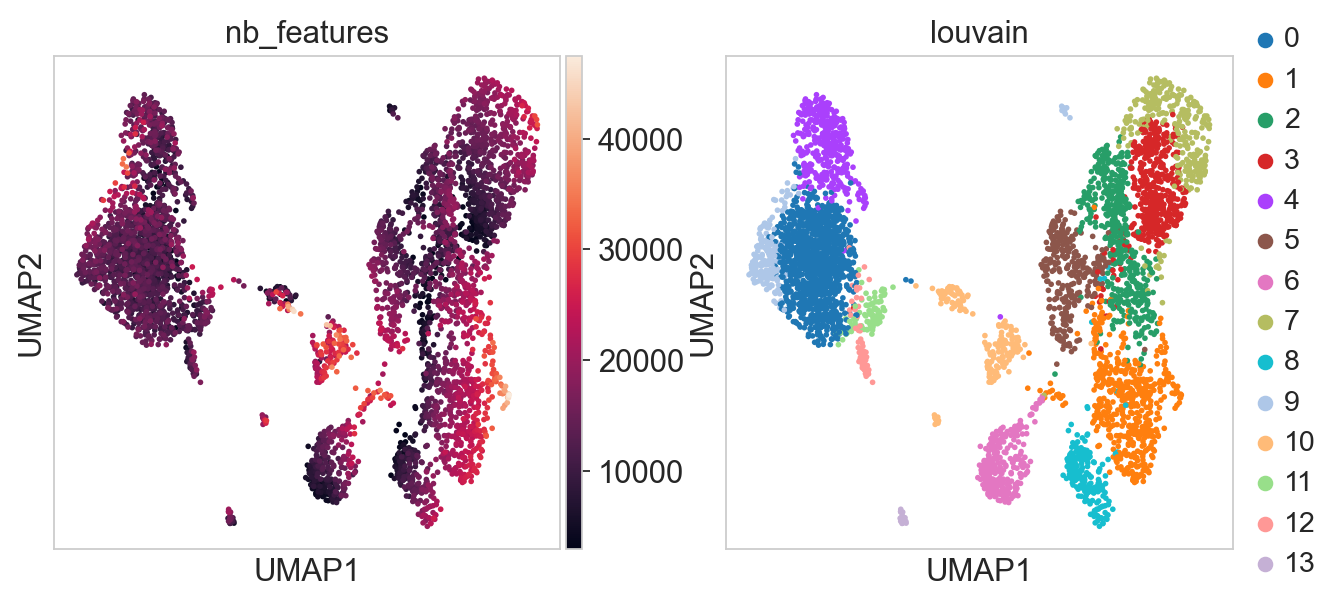

In [109]:
epi.tl.louvain(adata)
sc.pl.umap(adata, color=['nb_features', 'louvain'])

In [110]:
adata.write('epiScanpy_10xpbmc5k.h5ad')